In [1]:
import yfinance as yf
import numpy as np 
import pandas as pd
import matplotlib
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import scipy.stats as stats
from datetime import datetime, timedelta

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/Users/vinayak/opt/anaconda3/lib/python3.8/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [2]:
""" Retrieve Data from yfinance
    :type ticker: string
    :type startDate: string '%Y-%m-%d'
    :type endDate: string '%Y-%m-%d'
    :rtype: pandas dataframe
    -----------------------
    yf.Ticker() -> takes ticker and returns tuple of ticker objects
    .history()  -> returns datafram corresponding to period specified
"""
def pullData(ticker, startDate, endDate):
    return yf.Ticker(ticker).history(start=startDate, end=endDate)

""" Generate a Candlestick Plot
    :type df: pandas dataframe
    :type mav: tuple
    :type ticker: string
"""

""" Return price at a given day
    :type date: str or pandas timestamp
    :type df: pandas dataframe
    :rtype: float
"""  
def getPrice(date, df):
    if df.loc[df.index==date].empty:
        print("ERR: Unable to getPrice(), No trading data for",date)
    return df.loc[df.index==date]['Open'][0]

""" Return all local minimums and maximums for a given timeframe
    :type df: pandas dataframe
    :type start: str or pandas timestamp
    :type end: str or pandas timestamp
    :rtype: dict{date:price}
"""  
def get_Peaks_and_Valleys(df, start, end):
    peaks = {}
    valleys = {}
    
    days = ( pd.to_datetime(end) -  pd.to_datetime(start)).days

    for i in range(0,days,3):    
        startDate = pd.to_datetime(start) + timedelta(i)

        while df.loc[df.index==startDate].empty:
            startDate = startDate + timedelta(1)

        initial_state = state(date=startDate, price=getPrice(startDate, df))

        climb = problem_hillclimb(initial=initial_state, df=df, objective_function=getPrice, stepsize=1)
        out = hill_climb(climb, n_iter=50)
        peaks[out.date] = out.price

        initial_state = state(date=startDate, price=getPrice(startDate, df))
        fall = problem_hillfall(initial=initial_state, df=df, objective_function=getPrice, stepsize=1)
        out = hill_fall(fall, n_iter=50)
        valleys[out.date] = out.price
        
    return peaks, valleys

"""~~~~~~~~~~~ FOR HILLCLIMBING ~~~~~~~~~~~"""

""" Define State of problem as a date and a time """ 
class state:
    def __init__(self, date, price):
        self.date = date
        self.price = price
    
class problem:
    """ Maintain everything that defines the problem
    :type initial_state: Class state
    :type current_state: Class state
    :type objective_function: defined function
    :type stepsize: int
    :type df: pandas dataframe
    """ 
    def __init__(self, initial, df, objective_function, stepsize):
        self.initial_state = initial
        self.current_state = initial
        self.objective_function = objective_function
        self.stepsize = stepsize
        self.df = df
    
    """ Return possible moves to take
    :rtype: array of dates
    """  
    def moves(self):
        all_moves = []
        
        newMoveForward = self.current_state.date + timedelta(self.stepsize)
        newMoveBackward = self.current_state.date - timedelta(self.stepsize)
        
        while df.loc[df.index==newMoveForward].empty:
            newMoveForward = newMoveForward + timedelta(self.stepsize)
        while df.loc[df.index==newMoveBackward].empty:
            newMoveBackward = newMoveBackward - timedelta(self.stepsize)
            
        all_moves.append(newMoveBackward)
        all_moves.append(newMoveForward)
        
        return all_moves
        
""" Performs hill climbing
    :type problem: Class problem
    :type n_iter: int
    :rtype: if peak found: Class state
            if no peak found: False
"""  
def hill_climb(problem, n_iter):
    # for t in some number of iterations:
    #     1. get a list of our available moves
    #     2. which move optimizes the objective function?
    #     3. do that move; update our status
    #     4. possible goal/convergence check
    
    for i in range(n_iter):
        nextMove, nextValue = problem.best_move()
        
        if nextValue <= problem.current_state.price: return problem.current_state
        
        problem.current_state.date, problem.current_state.price = nextMove, nextValue
        
    print("Reached n iterations.")
    return False

class problem_hillclimb(problem):
    """ Choose date that has higher price
    :rtype: datetime, int
    """  
    def best_move(self):
        all_moves = self.moves()
        
        obj_func = [self.objective_function(moves, self.df) for moves in all_moves]
        
        if obj_func[0] > obj_func[1]: return all_moves[0], obj_func[0]
        
        else: return all_moves[1], obj_func[1]
        
""" Performs hill falling
    :type problem: Class problem
    :type n_iter: int
    :rtype: if peak found: Class state
            if no peak found: False
"""          
def hill_fall(problem, n_iter):
    # for t in some number of iterations:
    #     1. get a list of our available moves
    #     2. which move optimizes the objective function?
    #     3. do that move; update our status
    #     4. possible goal/convergence check
    
    for i in range(n_iter):
        nextMove, nextValue = problem.best_move()
        
        if nextValue >= problem.current_state.price: return problem.current_state
    
        problem.current_state.date, problem.current_state.price = nextMove, nextValue
        
    print("Reached n iterations.")
    return False
   
class problem_hillfall(problem):
    """ Choose date that has lower price
    :rtype: datetime, int
    """  
    def best_move(self):
        all_moves = self.moves()
        
        obj_func = [self.objective_function(moves, self.df) for moves in all_moves]
        
        if obj_func[0] < obj_func[1]: return all_moves[0], obj_func[0]

        else: return all_moves[1], obj_func[1]


In [3]:
ticker = 'AAPL'
startDate = '2014-12-01'
endDate = '2016-02-01'

df = pullData(ticker, startDate, endDate)
peaks, valleys = get_Peaks_and_Valleys(df, start='2015-01-01', end='2016-01-01')



In [79]:
##FINDING SUPPORT



def supportFinder():
    ##initialize vector containing all the pertinent support data
    inita = np.array(list([])) 
    initb = np.array(list([]))
    support = np.array(list(zip(inita,initb))) 

    ##initialize the bucket we want to use in our search for support data
    bucket = .001

    date = np.array(list(valleys.keys())) ## get all the dates from our dictonary result
    price = np.array(list(valleys.values())) ##get all the prices from our dictionary result
    z = np.array(list(zip(date,price))) ##zip as a 2d array
   


    for x in range(len(z)): ## for all values with index 0 to range(valleys)
        
        for y in range(x-1): ## for all values with index 0 to 

                if (abs ( (z[y][1]-z[x][1])  / (z[x][1]) ) < bucket): 
                        
                    
                        l = 0
                        counter = 0 
                        bucketFound = False 
                        
                        if(len(support) ==0):
                                    g = np.append(support, [z[y]]) 
                                    support = g
                        
                        for i in support:
                            
                            
                            if(counter%2==1):
                                
                                
                                
                                if (abs ( (i-z[x][1])  / (i) ) < bucket):
                                    
                                    bucketFound = True 

                                    
                            counter = counter+1
                        
                        
                        if(bucketFound == False):
                            
                        
                            g = np.append(support, [z[y]]) 
                            support = g
                            
                        
                            
                            
    return support
                        


In [80]:


s = supportFinder()
print("SUPPORT VALUES")
print(len(s))


supportDates= []
supportVals = []
counter22 = 0
counter20 = 0 
for i in s:
    if (counter22%2==0):
        supportDates.append(i)
    if(counter22%2 == 1):
        supportVals.append(i)
    counter22 = counter22+1
        
print(s)
#print(s)


SUPPORT VALUES
18
[Timestamp('2015-05-01 00:00:00') 28.88 Timestamp('2015-03-03 00:00:00')
 29.54 Timestamp('2015-06-18 00:00:00') 29.26
 Timestamp('2015-04-17 00:00:00') 28.75 Timestamp('2015-05-12 00:00:00')
 28.89 Timestamp('2015-07-10 00:00:00') 28.04
 Timestamp('2015-03-26 00:00:00') 28.12 Timestamp('2015-08-05 00:00:00')
 25.98 Timestamp('2015-01-14 00:00:00') 24.88]


In [81]:
def resistanceFinder():
    

    ##initialize vector containing all the pertinent support data
    inita = np.array(list([]))
    initb = np.array(list([]))
    resistance = np.array(list(zip(inita,initb)))

    ##initialize the bucket we want to use in our search for support data
    bucket = .01

    date = np.array(list(peaks.keys())) ## get all the dates from our dictonary result
    price = np.array(list(peaks.values())) ##get all the prices from our dictionary result
    z = np.array(list(zip(date,price))) ##zip as a 2d array

    for x in range(len(z)):
        for y in range(x-1):

                if (abs ( (z[y][1]-z[x][1])  / (z[x][1]) ) < bucket): 
                    
                        l = 0
                        counter = 0 
                        bucketFound = False 
                        
                        if(len(resistance) ==0):
                                    g = np.append(resistance, [z[y]]) 
                                    resistance = g
                        
                        for i in resistance:
                            
                            
                            if(counter%2==1):
                               
                                
                                if (abs ( (i-z[x][1])  / i ) < bucket):
                                    bucketFound = True 

                                    
                            counter = counter+1
                        
                        
                        if(bucketFound == False):
                            g = np.append(resistance, [z[y]]) 
                            resistance = g
                            
                        
                            
                            
    return resistance






                
                        

                        
                        
                            
                            
                           
                                
                                

In [82]:
print("RESISTANCE VALUES")
r = resistanceFinder()
resistanceDates= []
resistanceVals = []
counter22 = 0
counter20 = 0 
for i in r:
    if (counter22%2==0):
        resistanceDates.append(i)
    if(counter22%2 == 1):
        resistanceVals.append(i)
    counter22 = counter22+1
print(len(r))

print((resistanceDates[2]-resistanceDates[1]).days)


RESISTANCE VALUES
22
20


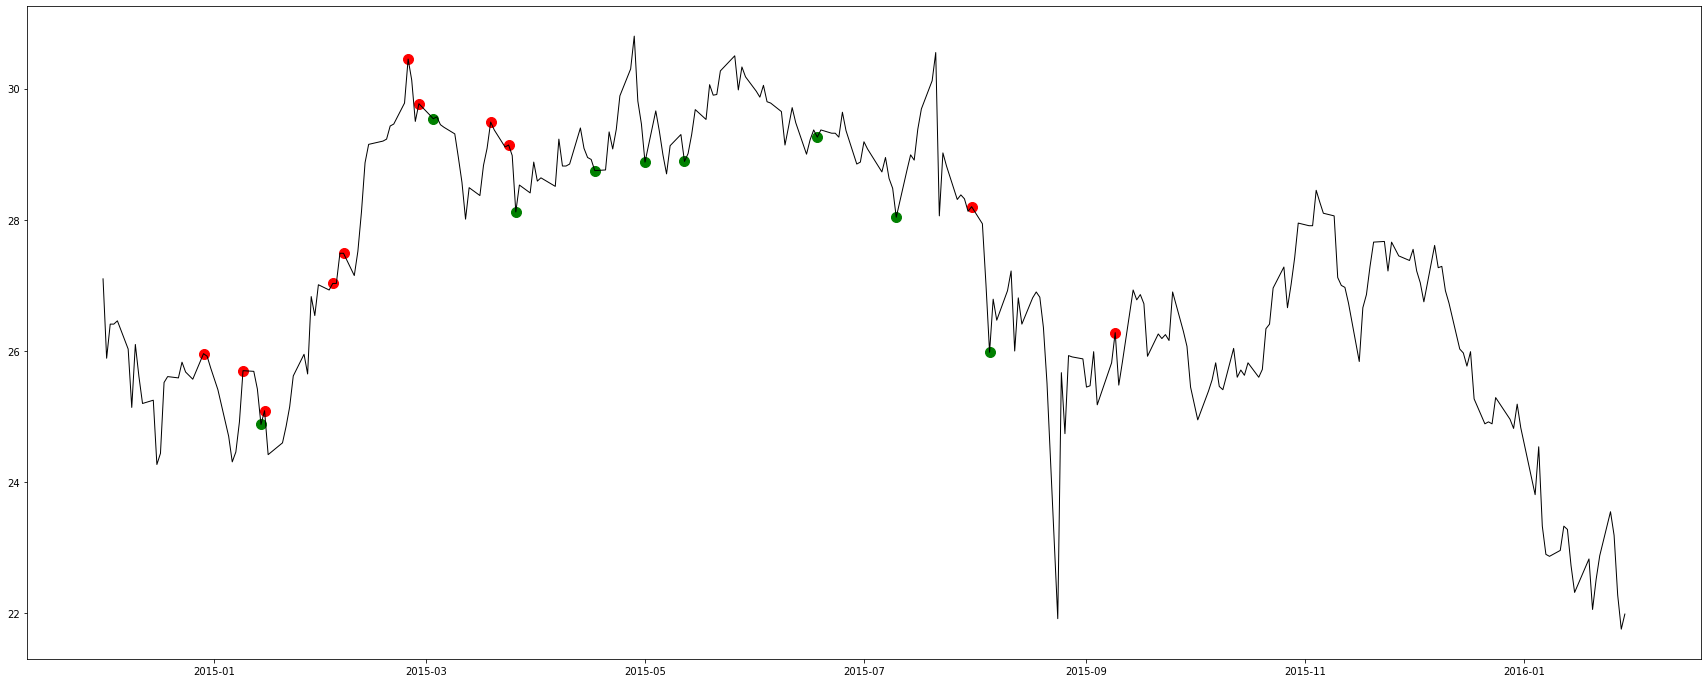

In [83]:
fig, ax = plt.subplots(figsize=(30,12))
ax.scatter(supportDates,supportVals,color='green',s=100, label = "Local Max")
ax.scatter(resistanceDates,resistanceVals,color='red',s=100, label = "Local Max")

ax.plot(df.index,df['Open'],color='black',lw=1)

In [84]:
import math
def findNearestSupport(day,value,s, supportDates, supportVals):
        
    nearestDate = 0
    nearestVal = 0
    for x in supportDates:
        nearestDate = x
    
    for y in supportVals:
        nearestVal = y
    if(nearestDate == 0):
        nearestDate = supportDates[0]
    euclideanDistance = math.sqrt(((nearestDate - day).days**2)+ ((nearestVal - value)**2))
    return euclideanDistance

def findNearestResistance(day,value,s, resistanceDates, resistanceVals):
    nearestDate = 0
    nearestVal = 0
    for x in resistanceDates:
        nearestDate = x
    
    for y in resistanceVals:
        nearestVal = y
    
    if(nearestDate == 0):
        nearestDate = resistanceDates[0]
     
    
    euclideanDistance = math.sqrt(((nearestDate - day).days**2)+ ((nearestVal - value)**2))
    return euclideanDistance
    
        
    
    

In [88]:
def EuclideanDistanceFinder(s,r):
    
    
     ## get all the dates from our dictonary result
    
    supportDates= []
    supportVals = []
    counter22 = 0
    counter20 = 0 
    for i in s:
        if (counter22%2==0):
            supportDates.append(i)
        if(counter22%2 == 1):
            supportVals.append(i)
        counter22 = counter22+1
        

        
    
    resistanceDates= []
    resistanceVals = []
    counter22 = 0
    counter20 = 0 
    
    for i in r:
        if (counter22%2==0):
            resistanceDates.append(i)
        if(counter22%2 == 1):
            resistanceVals.append(i)
        counter22 = counter22+1
        
  
    
    
    ResandSup= {}

    for x in df.index:
        valueForDay = df.loc[df.index==x]['Open'][0]
        
        euclidSup = findNearestSupport(x,valueForDay,s, supportDates, supportVals)
        euclidRes = findNearestResistance(x,valueForDay,s, resistanceDates, resistanceVals)
        
        ResandSup[x] = [euclidSup,euclidRes]
        

    return ResandSup
        
   
    
    

In [89]:
euclid = EuclideanDistanceFinder(s,r)
print(euclid)

{Timestamp('2014-12-01 00:00:00'): [44.05596894859992, 45.044867632173144], Timestamp('2014-12-02 00:00:00'): [43.01185999233235, 44.00727212632022], Timestamp('2014-12-03 00:00:00'): [42.02785861782634, 43.0202556942657], Timestamp('2014-12-04 00:00:00'): [41.028537629313576, 42.0207377374553], Timestamp('2014-12-05 00:00:00'): [40.03119283758604, 41.02288263883951], Timestamp('2014-12-08 00:00:00'): [37.01786730755838, 38.01162453776476], Timestamp('2014-12-09 00:00:00'): [36.00093887664598, 37.00003378376836], Timestamp('2014-12-10 00:00:00'): [35.02125640236226, 36.014165268682824], Timestamp('2014-12-11 00:00:00'): [34.007835861753975, 35.00386264399973], Timestamp('2014-12-12 00:00:00'): [33.00155147868051, 34.00017794071084], Timestamp('2014-12-15 00:00:00'): [30.00228157990655, 31.00041290047602], Timestamp('2014-12-16 00:00:00'): [29.006414807762784, 30.011204574291916], Timestamp('2014-12-17 00:00:00'): [28.003456929457833, 29.00728356809717], Timestamp('2014-12-18 00:00:00')